# Loading all the necessary packages

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121

# Creating train data and test data

In [2]:
# Path of the train and test directories
train_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/train'
test_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/test'

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rotation_range=40,                # Random rotation of images (0-40 degrees)
    width_shift_range=0.2,            # Random horizontal shift of images
    height_shift_range=0.2,           # Random vertical shift of images
    zoom_range=0.2,                   # Random zoom on images
    horizontal_flip=True,             # Random horizontal flip of images
    rescale=1/255.0                   # Rescale pixel values to [0, 1]
)

# Data preprocessing for test data (only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data from the directory
train_data = train_datagen.flow_from_directory(
    train_dir,                       # Path to the training data directory
    target_size=(150, 150),          # Resize images to (150, 150)
    class_mode='binary'              # Binary classification (muffin vs. chihuahua)
)

# Load the test data from the directory
test_data = test_datagen.flow_from_directory(
    test_dir,                        # Path to the test data directory
    target_size=(150, 150),          # Resize images to (150, 150)
    class_mode='binary',             # Binary classification (muffin vs. chihuahua)
    shuffle=False                    # Do not shuffle the test data
)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


# Loading a sample image from the dataset

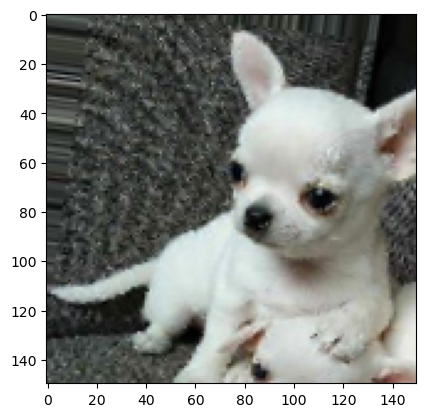

In [3]:
import matplotlib.pyplot as plt
plt.imshow(train_data[0][0][0])

# VGG19 model

In [10]:
# Create a VGG19 model with pre-trained weights from ImageNet
vgg_model = VGG19(include_top=False,
                  weights='imagenet',          # Load pre-trained weights
                  input_shape=(150, 150, 3),   # Input image shape
                  classes=2)                   # Number of classes (2 for binary classification)

# Freeze the layers of the VGG19 model up to the 10th layer
# This means only the last few layers will be trainable during fine-tuning
for layer in vgg_model.layers[10:]:
    layer.trainable = False

# Get the output from the VGG19 model
inputs = vgg_model.output

# Flatten the output to connect to the fully connected layers
x = Flatten()(inputs)

# Add a fully connected dense layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add another fully connected dense layer with 256 units and ReLU activation
x = Dense(256, activation='relu')(x)

# Add the output layer with 1 unit and sigmoid activation for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the custom model by specifying the input and output layers
vgg_model = Model(vgg_model.inputs, outputs)

#Printing the summary
# model1.summary()

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model using binary crossentropy loss, Adam optimizer, and accuracy as the metric
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model using the train_data generator for training and test_data generator for validation
# with 10 epochs
vgg_history = vgg_model.fit(train_data, validation_data=test_data, epochs=30)

Epoch 1/30
148/148 [==============================] - 173s 1s/step - loss: 0.5497 - accuracy: 0.7053 - val_loss: 0.3383 - val_accuracy: 0.8699
Epoch 2/30
148/148 [==============================] - 94s 636ms/step - loss: 0.3640 - accuracy: 0.8487 - val_loss: 0.3006 - val_accuracy: 0.8708
Epoch 3/30
148/148 [==============================] - 94s 634ms/step - loss: 0.3393 - accuracy: 0.8612 - val_loss: 0.2983 - val_accuracy: 0.8792
Epoch 4/30
148/148 [==============================] - 95s 638ms/step - loss: 0.3060 - accuracy: 0.8798 - val_loss: 0.2817 - val_accuracy: 0.8843
Epoch 5/30
148/148 [==============================] - 100s 673ms/step - loss: 0.2838 - accuracy: 0.8901 - val_loss: 0.2232 - val_accuracy: 0.9113
Epoch 6/30
148/148 [==============================] - 99s 664ms/step - loss: 0.2681 - accuracy: 0.8986 - val_loss: 0.1999 - val_accuracy: 0.9206
Epoch 7/30
148/148 [==============================] - 94s 636ms/step - loss: 0.2536 - accuracy: 0.9007 - val_loss: 0.2108 - val_acc

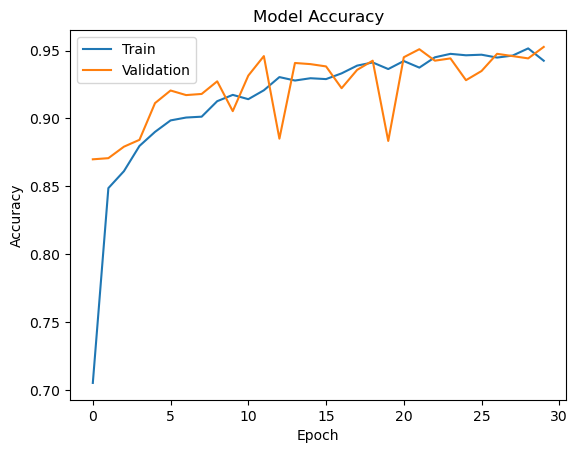

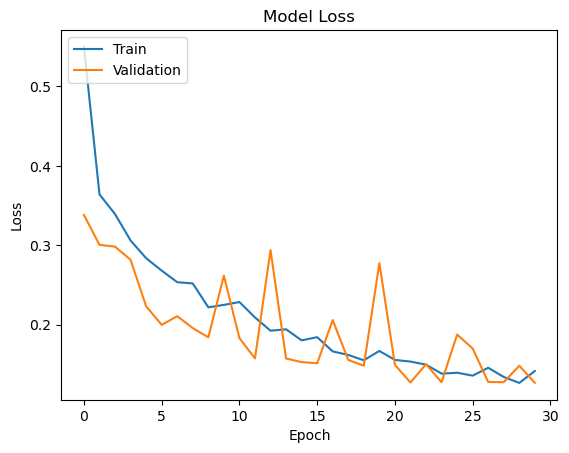

In [12]:
# Plot training & validation accuracy values
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('vggmodel_accuracy_graph.png')
plt.savefig('vggmodel_accuracy_graph.jpg')
plt.show()

# Plot training & validation loss values
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('vggmodel_loss_graph.png')
plt.savefig('vggmodel_loss_graph.jpg')
plt.show()

In [13]:
# Make predictions on the test dataset
y_pred = vgg_model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels from the test dataset
y_true = test_data.labels

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
# Calculate the accuracy
vgg_model_accuracy = metrics.accuracy_score(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", vgg_model_accuracy)

37/37 [==============================] - 14s 388ms/step
Confusion Matrix:
[[626  14]
 [ 42 502]]
Accuracy: 0.9527027027027027


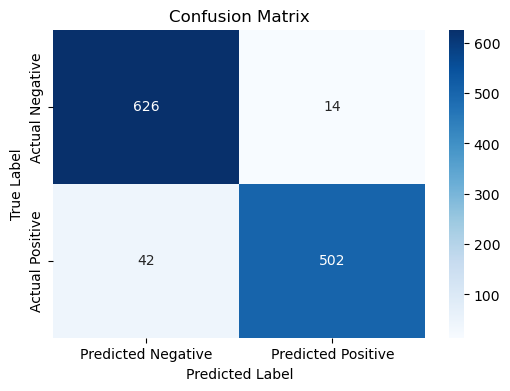

In [14]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('vggmodel.png')
plt.show()

# ResNet Model

In [15]:
# Create the ResNet50 base model with pre-trained weights from ImageNet
resnet_model = ResNet50(include_top=False,
                        weights='imagenet',
                        input_shape=(150, 150, 3))

# Optionally, freeze layers up to a certain point to prevent them from being trained
# In this example, layers from index 35 onwards will be frozen
for layer in resnet_model.layers[35:]:
    layer.trainable = False

# Add custom classification layers on top of the ResNet50 base model
inputs = resnet_model.output
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the custom ResNet model with the added classification layers
resnet_model = Model(inputs=resnet_model.inputs, outputs=outputs)

# model2.summary()

94765736/94765736 [==============================] - 1s 0us/step


In [16]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data and validate it on the test data for 20 epochs
resnet_history = resnet_model.fit(train_data, validation_data=test_data, epochs=30)

Epoch 1/30
148/148 [==============================] - 107s 651ms/step - loss: 1.0102 - accuracy: 0.9149 - val_loss: 2.7681 - val_accuracy: 0.5405
Epoch 2/30
148/148 [==============================] - 93s 631ms/step - loss: 0.1114 - accuracy: 0.9624 - val_loss: 2.5161 - val_accuracy: 0.5405
Epoch 3/30
148/148 [==============================] - 93s 627ms/step - loss: 0.0684 - accuracy: 0.9770 - val_loss: 1.4574 - val_accuracy: 0.5405
Epoch 4/30
148/148 [==============================] - 100s 675ms/step - loss: 0.1066 - accuracy: 0.9626 - val_loss: 1.3423 - val_accuracy: 0.5524
Epoch 5/30
148/148 [==============================] - 93s 630ms/step - loss: 0.0858 - accuracy: 0.9708 - val_loss: 1.1839 - val_accuracy: 0.6284
Epoch 6/30
148/148 [==============================] - 94s 634ms/step - loss: 0.0839 - accuracy: 0.9689 - val_loss: 0.1513 - val_accuracy: 0.9409
Epoch 7/30
148/148 [==============================] - 92s 625ms/step - loss: 0.0795 - accuracy: 0.9723 - val_loss: 0.1010 - val_

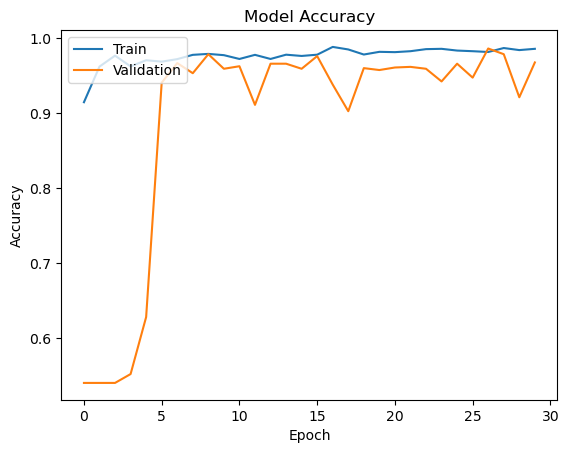

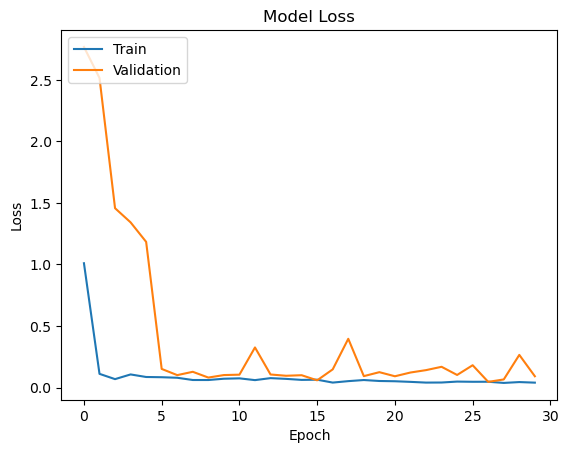

In [17]:
# Plot training & validation accuracy values
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('resnet_accuracy_graph.png')
plt.savefig('resnet_accuracy_graph.jpg')
plt.show()

# Plot training & validation loss values
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('resnet_loss_graph.png')
plt.savefig('resnet_loss_graph.jpg')
plt.show()

In [18]:
# Make predictions on the test dataset
y_pred = resnet_model.predict(test_data)  # Predict probabilities for each sample
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Get true labels from the test dataset
y_true = test_data.labels

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Calculate the accuracy
resnet_model_accuracy = metrics.accuracy_score(y_true, y_pred)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", resnet_model_accuracy)

37/37 [==============================] - 15s 384ms/step
Confusion Matrix:
[[605  35]
 [  3 541]]
Accuracy: 0.9679054054054054


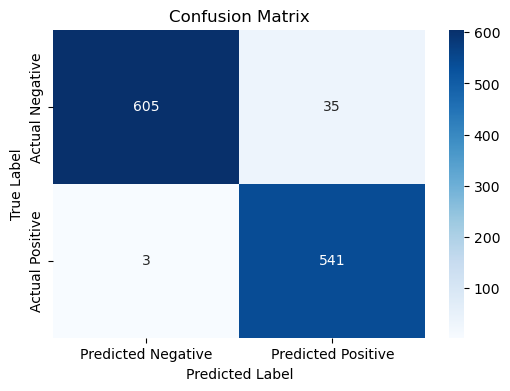

In [19]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('resnetmodel.png')
plt.show()

# Inception Model

In [7]:
# Create the InceptionV3 model
inception_model = InceptionV3(include_top=False,
                              weights='imagenet',
                              input_shape=(150, 150, 3))

# Freeze layers up to a certain point (optional)
for layer in inception_model.layers[25:]:
    layer.trainable = False

# Add custom classification layers
inputs = inception_model.output
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the custom InceptionV3 model
inception_model = Model(inputs=inception_model.inputs, outputs=outputs)

# Display the model summary
# inception_model.summary()

87910968/87910968 [==============================] - 4s 0us/step


In [8]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with binary crossentropy loss, Adam optimizer, and accuracy metric
inception_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data and validate it on the test data for 10 epochs
inception_history = inception_model.fit(train_data, validation_data=test_data, epochs=30, callbacks=[early_stopping])

Epoch 1/30
148/148 [==============================] - 143s 867ms/step - loss: 1.1203 - accuracy: 0.9068 - val_loss: 0.0969 - val_accuracy: 0.9628
Epoch 2/30
148/148 [==============================] - 95s 640ms/step - loss: 0.0878 - accuracy: 0.9711 - val_loss: 0.0634 - val_accuracy: 0.9789
Epoch 3/30
148/148 [==============================] - 94s 633ms/step - loss: 0.0882 - accuracy: 0.9702 - val_loss: 0.2479 - val_accuracy: 0.9459
Epoch 4/30
148/148 [==============================] - 93s 631ms/step - loss: 0.0898 - accuracy: 0.9685 - val_loss: 0.0821 - val_accuracy: 0.9755
Epoch 5/30
148/148 [==============================] - 94s 636ms/step - loss: 0.0857 - accuracy: 0.9717 - val_loss: 0.0576 - val_accuracy: 0.9730
Epoch 6/30
148/148 [==============================] - 93s 632ms/step - loss: 0.0757 - accuracy: 0.9742 - val_loss: 0.0429 - val_accuracy: 0.9848
Epoch 7/30
148/148 [==============================] - 93s 629ms/step - loss: 0.0681 - accuracy: 0.9776 - val_loss: 0.1236 - val_a

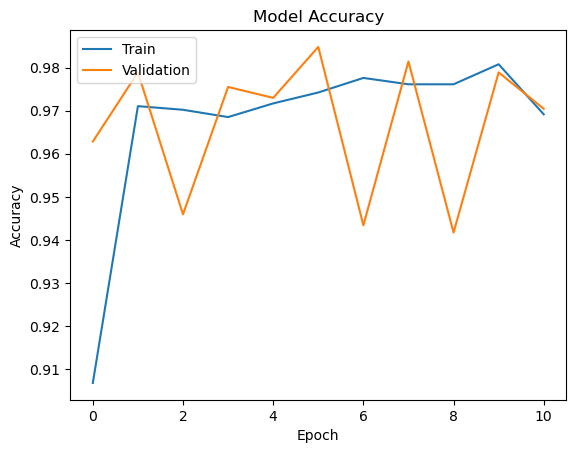

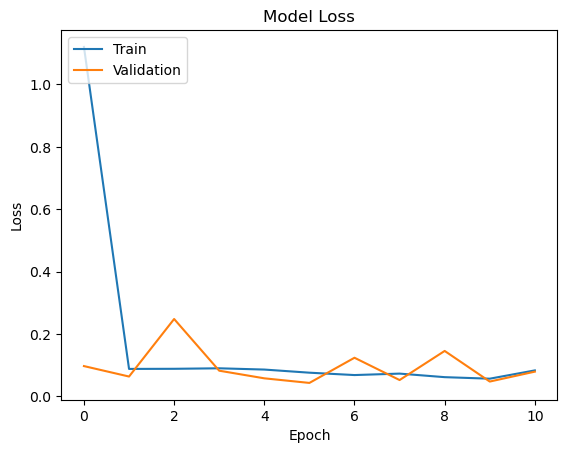

In [11]:
# Plot training & validation accuracy values
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('inception_accuracy_graph.png')
plt.savefig('inception_accuracy_graph.jpg')
plt.show()

# Plot training & validation loss values
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('inception_loss_graph.png')
plt.savefig('inception_loss_graph.jpg')
plt.show()

In [13]:
# Make predictions on the test dataset
y_pred = inception_model.predict(test_data)

# Convert probabilities to binary predictions by thresholding at 0.5
y_pred = (y_pred > 0.5).astype(int)

# Get true labels from the test dataset
y_true = test_data.labels

# Calculate the confusion matrix using scikit-learn's metrics
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Calculate the accuracy using scikit-learn's accuracy_score function
inception_model_accuracy = metrics.accuracy_score(y_true, y_pred)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", inception_model_accuracy)

37/37 [==============================] - 18s 452ms/step
Confusion Matrix:
[[632   8]
 [ 10 534]]
Accuracy: 0.9847972972972973


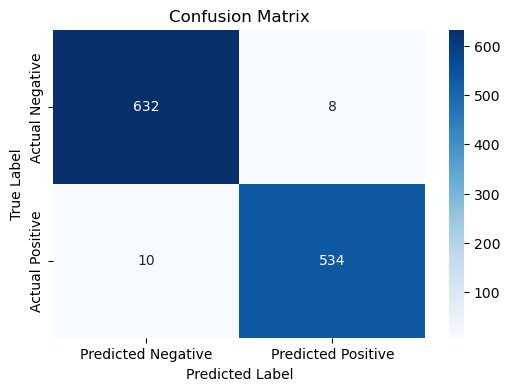

In [14]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('inceptionmodel.png')
plt.show()

# DenseNet Model

In [8]:
# Create the DenseNet121 model with pre-trained weights
densenet_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=(150, 150, 3))

# Freeze layers up to a certain point (optional)
for layer in densenet_model.layers[60:]:
    layer.trainable = False

# Add custom classification layers
inputs = densenet_model.output
x = Flatten()(inputs)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the custom model by specifying inputs and outputs
densenet_model = Model(densenet_model.inputs, outputs)

# model5.summary()


In [10]:
# Compile the model with binary cross-entropy loss, Adam optimizer, and accuracy metric
densenet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the training data and validate it on the test data for 15 epochs
densenet_history = densenet_model.fit(train_data, validation_data=test_data, epochs=30)

Epoch 1/30
148/148 [==============================] - 119s 695ms/step - loss: 0.3712 - accuracy: 0.8916 - val_loss: 0.8210 - val_accuracy: 0.7475
Epoch 2/30
148/148 [==============================] - 95s 644ms/step - loss: 0.1692 - accuracy: 0.9387 - val_loss: 0.1117 - val_accuracy: 0.9611
Epoch 3/30
148/148 [==============================] - 100s 675ms/step - loss: 0.1293 - accuracy: 0.9529 - val_loss: 0.1536 - val_accuracy: 0.9383
Epoch 4/30
148/148 [==============================] - 99s 672ms/step - loss: 0.1165 - accuracy: 0.9592 - val_loss: 0.3259 - val_accuracy: 0.8674
Epoch 5/30
148/148 [==============================] - 101s 680ms/step - loss: 0.1391 - accuracy: 0.9503 - val_loss: 0.0772 - val_accuracy: 0.9662
Epoch 6/30
148/148 [==============================] - 98s 663ms/step - loss: 0.1065 - accuracy: 0.9607 - val_loss: 0.1233 - val_accuracy: 0.9535
Epoch 7/30
148/148 [==============================] - 106s 715ms/step - loss: 0.1010 - accuracy: 0.9651 - val_loss: 0.0579 - va

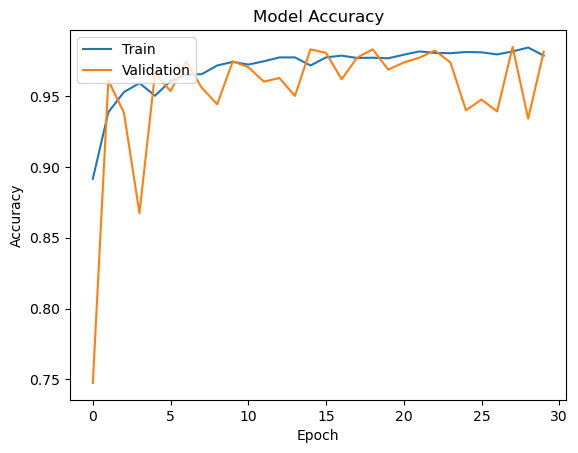

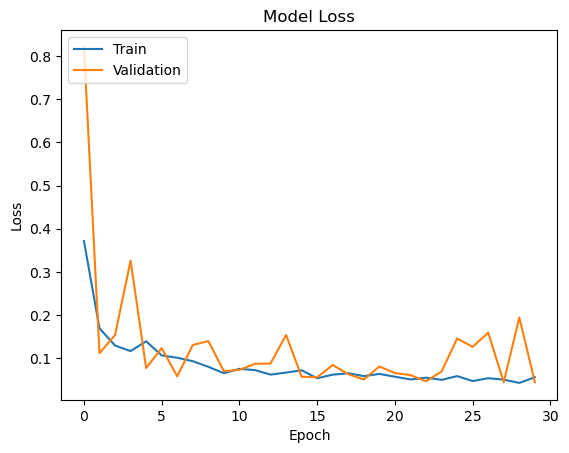

In [11]:
# Plot training & validation accuracy values
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('densenet_accuracy_graph.png')
plt.savefig('densenet_accuracy_graph.jpg')
plt.show()

# Plot training & validation loss values
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('densenet_loss_graph.png')
plt.savefig('densenet_loss_graph.jpg')
plt.show()

In [12]:
# Make predictions on the test dataset
y_pred = densenet_model.predict(test_data)

# Convert probabilities to binary predictions by setting a threshold of 0.5
y_pred = (y_pred > 0.5).astype(int)

# Get true labels from the test dataset
y_true = test_data.labels

# Calculate the confusion matrix using scikit-learn's confusion_matrix function
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

# Calculate the accuracy using scikit-learn's accuracy_score function
densenet_model_accuracy = metrics.accuracy_score(y_true, y_pred)

# Print the confusion matrix and accuracy
print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", densenet_model_accuracy)


37/37 [==============================] - 17s 399ms/step
Confusion Matrix:
[[627  13]
 [  9 535]]
Accuracy: 0.981418918918919


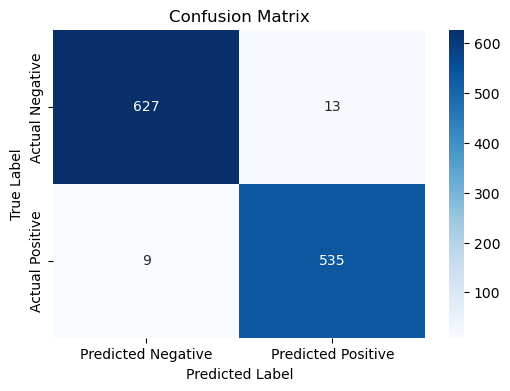

In [13]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('densenetmodel.png')
plt.show()

# Accuracy of the various models

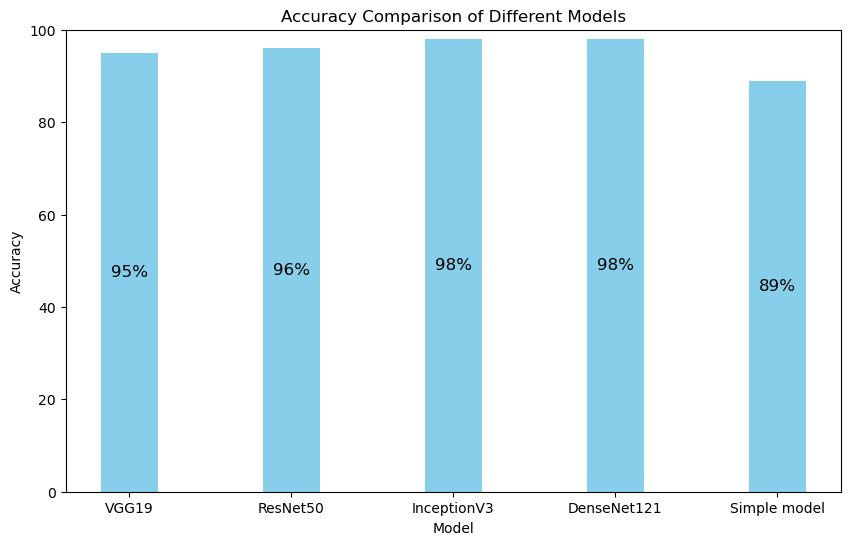

In [5]:
model_names = ['VGG19', 'ResNet50', 'InceptionV3', 'DenseNet121', 'Simple model']
accuracies = [95, 96, 98, 98, 89]

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue', width=0.35)  # Adjust the width as needed
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentage values

# Add accuracy values with percentage inside each bar
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{accuracy}%',
             ha='center', va='center', color='black', fontsize=12)
plt.savefig('model_accuracies.png')
plt.show()


# Shallow CNN model

In [27]:
# Path of the train and test directories
train_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/train'
test_dir = '/kaggle/input/muffin-vs-chihuahua-image-classification/test'

# Data augmentation and preprocessing for training data
train_datagen = ImageDataGenerator(
    rotation_range=40,                # Random rotation of images (0-40 degrees)
    width_shift_range=0.2,            # Random horizontal shift of images
    height_shift_range=0.2,           # Random vertical shift of images
    zoom_range=0.2,                   # Random zoom on images
    horizontal_flip=True,             # Random horizontal flip of images
    rescale=1/255.0                   # Rescale pixel values to [0, 1]
)

# Data preprocessing for test data (only rescale)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data from the directory
train_data = train_datagen.flow_from_directory(
    train_dir,                       # Path to the training data directory
    target_size=(64, 64),          # Resize images to (150, 150)
    class_mode='binary'              # Binary classification (muffin vs. chihuahua)
)

# Load the test data from the directory
test_data = test_datagen.flow_from_directory(
    test_dir,                        # Path to the test data directory
    target_size=(64, 64),          # Resize images to (150, 150)
    class_mode='binary',             # Binary classification (muffin vs. chihuahua)
    shuffle=False                    # Do not shuffle the test data
)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a Sequential model
cnn = Sequential()

# Add Convolutional layers
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(64, 64, 3)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten the output for fully connected layers
cnn.add(Flatten())

# Add Fully Connected layers
cnn.add(Dense(units=128, activation='relu'))
cnn.add(Dense(units=64, activation='relu'))

# Output layer (binary classification)
cnn.add(Dense(units=1, activation='sigmoid'))


In [29]:
# Compile the model
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
history = cnn.fit(train_data, validation_data=test_data, epochs=30)


Epoch 1/30
148/148 [==============================] - 78s 513ms/step - loss: 0.5948 - accuracy: 0.6683 - val_loss: 0.4500 - val_accuracy: 0.8049
Epoch 2/30
148/148 [==============================] - 71s 482ms/step - loss: 0.4888 - accuracy: 0.7640 - val_loss: 0.4389 - val_accuracy: 0.7931
Epoch 3/30
148/148 [==============================] - 70s 476ms/step - loss: 0.4125 - accuracy: 0.8206 - val_loss: 0.3190 - val_accuracy: 0.8691
Epoch 4/30
148/148 [==============================] - 71s 481ms/step - loss: 0.3892 - accuracy: 0.8363 - val_loss: 0.4448 - val_accuracy: 0.7905
Epoch 5/30
148/148 [==============================] - 71s 478ms/step - loss: 0.3716 - accuracy: 0.8426 - val_loss: 0.2988 - val_accuracy: 0.8792
Epoch 6/30
148/148 [==============================] - 71s 478ms/step - loss: 0.3694 - accuracy: 0.8420 - val_loss: 0.3218 - val_accuracy: 0.8471
Epoch 7/30
148/148 [==============================] - 72s 485ms/step - loss: 0.3596 - accuracy: 0.8515 - val_loss: 0.2834 - val_ac

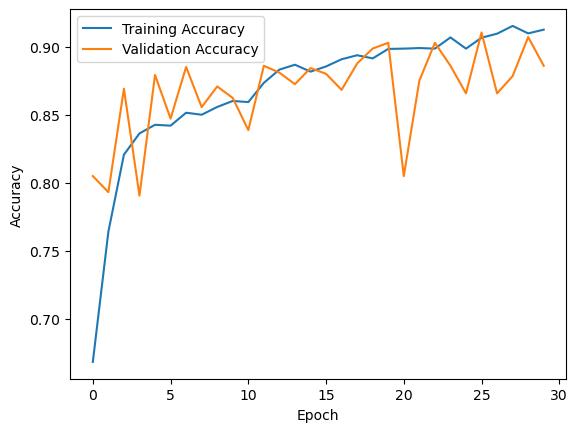

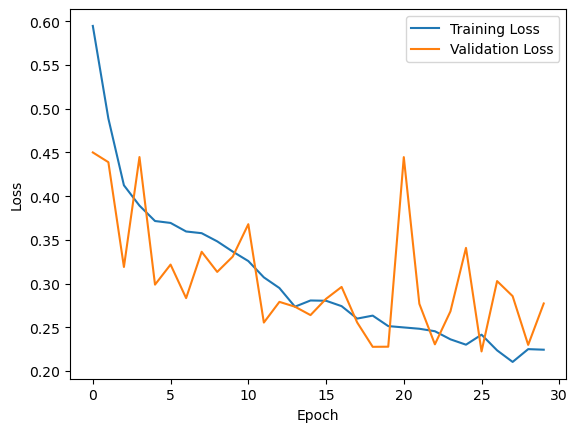

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('simple_accuracy_graph.png')
plt.savefig('simple_accuracy_graph.jpg')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('simple_loss_graph.png')
plt.savefig('simple_loss_graph.jpg')
plt.show()


In [31]:
# Make predictions on the test dataset
y_pred = cnn.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Get true labels from the test dataset
y_true = test_data.labels

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
# Calculate the accuracy
shallow_model_accuracy = metrics.accuracy_score(y_true, y_pred)

print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", shallow_model_accuracy)

37/37 [==============================] - 14s 380ms/step
Confusion Matrix:
[[583  57]
 [ 78 466]]
Accuracy: 0.8859797297297297


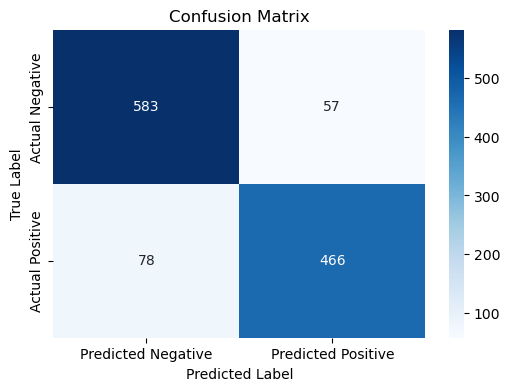

In [33]:
# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(confusion_matrix, index=['Actual Negative', 'Actual Positive'], 
                     columns=['Predicted Negative', 'Predicted Positive'])

# Plot the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('simplemodel.png')
plt.show()